In [1]:
import sys
import time
import sklearn
import matplotlib
import numpy as np
from keras.datasets import mnist
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

print('Python: {}'.format(sys.version))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Numpy: {}'.format(np.__version__))

Using TensorFlow backend.


Python: 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Sklearn: 0.22.1
Matplotlib: 3.1.3
Numpy: 1.18.1


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


# Visualize the images

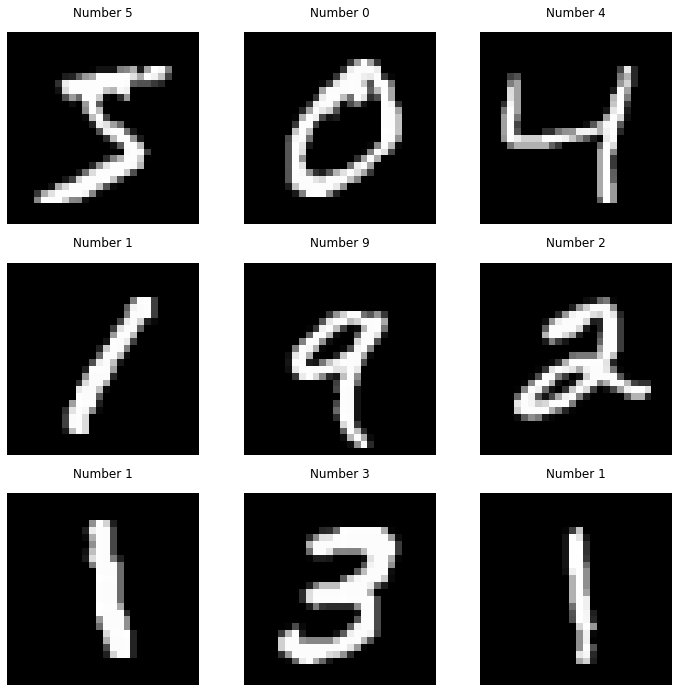

In [3]:
# create sbplots using matplotlib.pyplot and 
# populate the plots with data
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))

In [4]:
# Preprocessing the images

# Convert the images to 1D arrays

x = x_train.reshape(len(x_train), -1)
# y_train is already 1D
y = y_train
# Normalize the Data to 0-1 from 0-255

x = x.astype(float)/255.
print(x.shape)
print(x[0].shape)


(60000, 784)
(784,)


# Create and Fit the model

In [5]:
n_digits = len(np.unique(y_test))
print(n_digits)

#Initilaize the KMeans model
kmeans = MiniBatchKMeans(n_clusters=n_digits)

#Fit the model
kmeans.fit(x)

10


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [6]:
kmeans.labels_[:20]

array([9, 3, 4, 5, 6, 8, 1, 9, 1, 6, 9, 5, 0, 7, 1, 6, 8, 5, 1, 6],
      dtype=int32)

In [7]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associate the cluster name to right label and
    return dictionary of clusters assigned to each label
    """
    inferred_labels = {}
    for i in range(kmeans.n_clusters):
        # Find the index of points in the cluster
        labels = []
        index = np.where(kmeans.labels_ == i)
        
        # Append actual label for each point in the cluster
        labels.append(actual_labels[index])
        
        # Determine most commen labels
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))
            
        #Assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            
            # Append the new number to the existing array at this key
            inferred_labels[np.argmax(counts)].append(i)
        else:
            
            #Create a new array for this key
            inferred_labels[np.argmax(counts)] = [i]
    return inferred_labels

def infer_data_labels(x_labels, cluster_labels):
    """
    Determines label for each array (for each example i.e 1D image) based on the cluster it has been assigned to
    return perdicted labels for each array
    """
    # Empty array(len)
    perdicted_labels = np.zeros(len(x_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(x_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                perdicted_labels[i] = key
    return perdicted_labels  

In [8]:
# Test the infer_cluster_labels() and infer_data_labels()
cluster_labels = infer_cluster_labels(kmeans, y)
x_clusters = kmeans.labels_
#x_clusters = kmeans.predict(x)
predicted_labels = infer_data_labels(x_clusters, cluster_labels)
print(predicted_labels[:20])
print(y[:20])
print(cluster_labels)

[8 0 4 1 9 2 1 8 1 9 8 1 3 6 1 9 2 1 1 9]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
{3: [0], 1: [1, 5], 7: [2], 0: [3], 4: [4], 9: [6], 6: [7], 2: [8], 8: [9]}


In [9]:
#Optimizing and evaluatiing clustering algorithms

def calculate_matrics(estimator, data, labels):
    
    #calculate and print matrics
    
    print('Number of clusters {}'.format(estimator.n_clusters))
    print('Inertia {}'.format(estimator.inertia_))
    print('Homogeneity {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))
    

In [10]:
clusters = [10, 16, 36, 64, 144, 256]

#test different number of clusters

for n_clusters in clusters:
    tic = time.perf_counter()
    estimator = MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(x)
    
    #print cluster matrics
    calculate_matrics(estimator, x, y)
    
    #determine perdicted labels
    cluster_labels = infer_cluster_labels(estimator, y)
    predicted_y = infer_data_labels(estimator.labels_, cluster_labels)
    
    
    #calculate and print accuracy
    print('Accuracy {}'.format(metrics.accuracy_score(y, predicted_y)))
    toc = time.perf_counter()
    print('Time {}\n'.format(toc-tic))

Number of clusters 10
Inertia 2456927.144243487
Homogeneity 0.40294231755951027
Accuracy 0.48486666666666667
Time 3.2378446349976002

Number of clusters 16
Inertia 2216892.398104704
Homogeneity 0.542693420145785
Accuracy 0.62675
Time 6.540645332999702

Number of clusters 36
Inertia 1956506.5267765303
Homogeneity 0.6918071874648717
Accuracy 0.7606666666666667
Time 11.718426381004974

Number of clusters 64
Inertia 1815095.6658977696
Homogeneity 0.7530501726722418
Accuracy 0.8326666666666667
Time 19.434749088002718

Number of clusters 144
Inertia 1630921.923268235
Homogeneity 0.8095248285865465
Accuracy 0.87315
Time 41.43187031100388

Number of clusters 256
Inertia 1516640.575585351
Homogeneity 0.8361409103371641
Accuracy 0.887
Time 67.8268387950011



In [11]:
#test the accuracy on the test data
#convert each image to 1D array
X_test = x_test.reshape(len(x_test), -1)

#normalize the data
X_test = X_test.astype(float)/255.

kmeans = MiniBatchKMeans(n_clusters=256)
kmeans.fit(x)
cluster_labels = infer_cluster_labels(kmeans, y)

#predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(test_clusters, cluster_labels)

#calculate and predict accuracy
print('Accuracy test data {}'.format(metrics.accuracy_score(y_test, predicted_labels)))

Accuracy test data 0.9035


/home/asad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


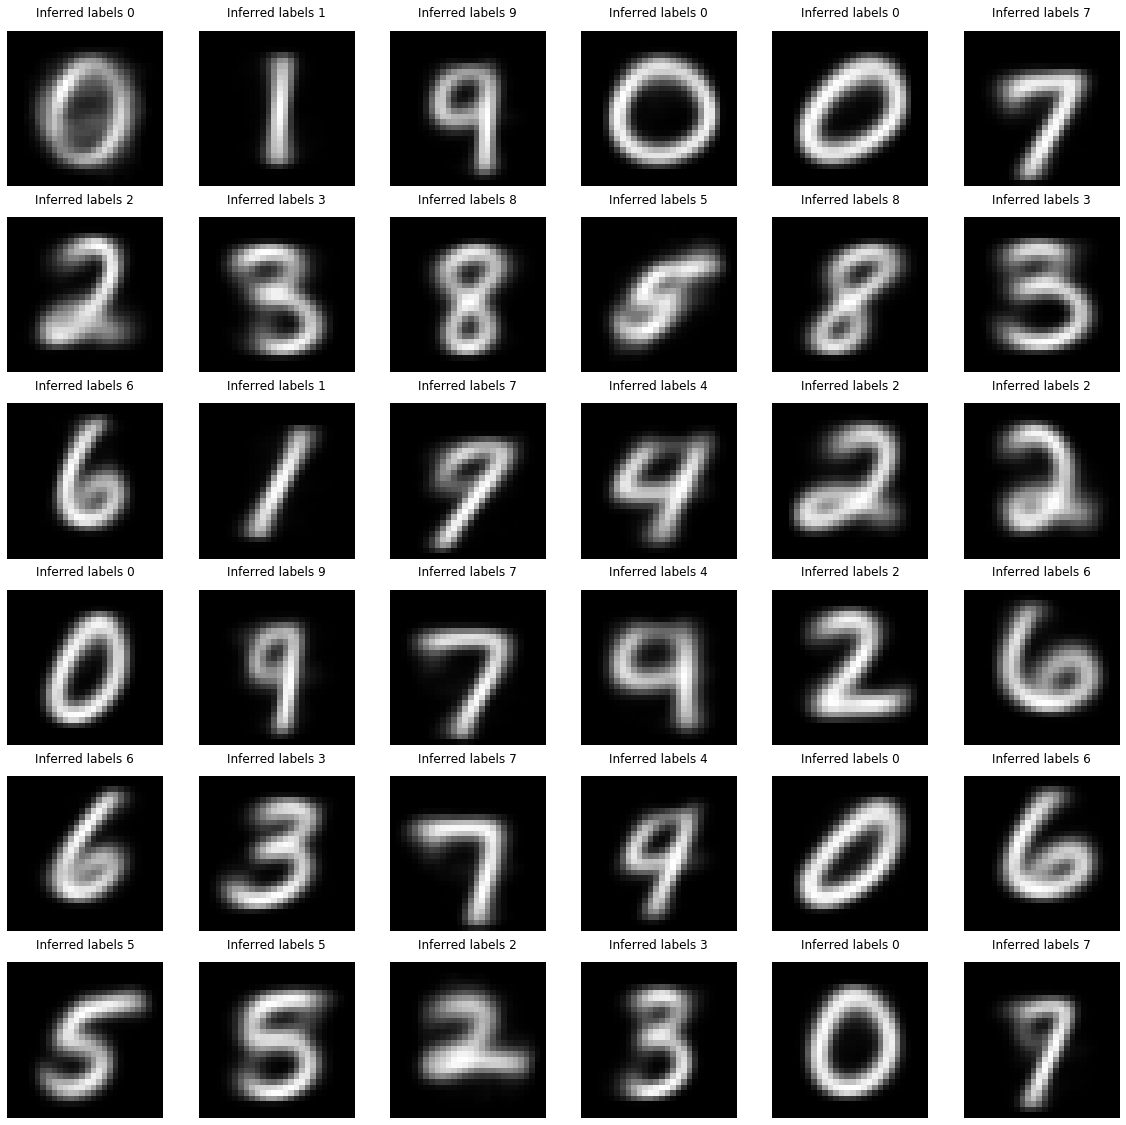

In [12]:
#visualize cluster centroids
#initialize a fit Kmeans alorithm
kmeans = MiniBatchKMeans(n_clusters=36)
kmeans.fit(x)

#record centroid values
centriods = kmeans.cluster_centers_

#reshape centroids into images
images = centriods.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

#determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, y)

#create a fig with subplots with matplotlib
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

#loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    #determine the inferred labeles using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred labels {}'.format(key))
    
    #add images to subplots
    ax.matshow(images[i])
    ax.axis('off')
    
#display the figure
fig.show()

        